Đánh giá Pipeline NER và RE

Notebook này thực hiện 3 nhiệm vụ chính:
1. Đánh giá riêng lẻ mô hình NER (SpaCy).
2. Đánh giá riêng lẻ các mô hình RE (4 Vectorizers x 4 Models) trên Gold Standard Entities.
3. Đánh giá Pipeline kết hợp (NER -> RE): Dùng output của NER làm input cho RE.

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Thêm đường dẫn src
CURRENT_DIR = Path(os.getcwd())
BASE_DIR = CURRENT_DIR.parent
SRC_DIR = os.path.join(BASE_DIR, 'src')
sys.path.append(SRC_DIR)

from evaluate import evaluate_re_module, inference_pipeline, evaluate_pipeline
from utils import MODEL_DIR, DATA_DIR

# Định nghĩa đường dẫn
TEST_JSON = os.path.join(DATA_DIR, 'processed', 'test_tasks.json')
TEST_CSV = os.path.join(DATA_DIR, 'processed', 'test_data.csv')
NER_MODEL_PATH = os.path.join(MODEL_DIR, 'ner_bert_model')

c:\Users\ASUS\anaconda3\envs\mynewenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== ĐÁNH GIÁ CHI TIẾT MÔ HÌNH RE ===

Model: bow + MLPDeepLearning
Accuracy: 0.6120
F1-Macro: 0.5329


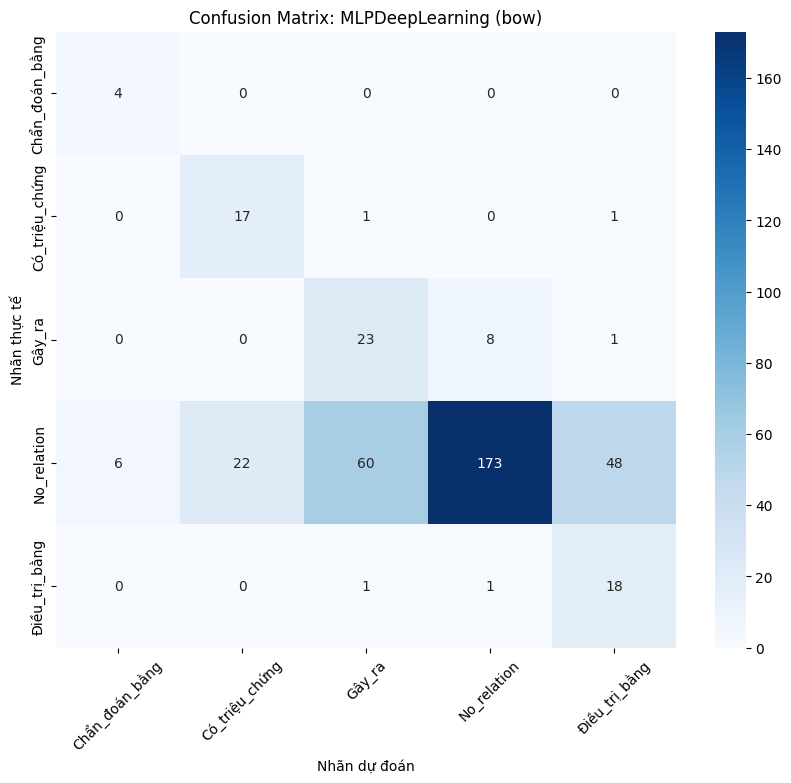

In [5]:
# Cell 2: Đánh giá chi tiết RE Module (Acc + Confusion Matrix)
print("=== ĐÁNH GIÁ CHI TIẾT MÔ HÌNH RE ===")

# Chọn model tốt nhất của cậu để vẽ (Ví dụ: BoW + RandomForest)
# Cậu có thể thay đổi tên vectorizer và model ở đây
target_vec = 'bow'
target_model = 'MLPDeepLearning'

metrics = evaluate_re_module(TEST_CSV, target_vec, target_model)

if metrics:
    print(f"\nModel: {target_vec} + {target_model}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1-Macro: {metrics['f1_macro']:.4f}")
    
    # Vẽ Confusion Matrix
    cm = metrics['confusion_matrix']
    classes = metrics['classes']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix: {target_model} ({target_vec})')
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Chưa tìm thấy model này.")


In [7]:
# Cell 3: Đánh giá Pipeline (NER -> RE)
print("\nTHÍ NGHIỆM 3: ĐÁNH GIÁ TOÀN BỘ PIPELINE")

target_vec = 'bow'
target_model = 'MLPDeepLearning'

pipeline_f1 = evaluate_pipeline(TEST_JSON, NER_MODEL_PATH, target_vec, target_model)


THÍ NGHIỆM 3: ĐÁNH GIÁ TOÀN BỘ PIPELINE

--- ĐÁNH GIÁ PIPELINE: NER + RE (bow - MLPDeepLearning) ---
Tổng Gold: 75, Tổng Pred: 112, Đúng: 29
Pipeline F1: 0.3102 (P=0.2589, R=0.3867)


In [8]:
# Cell 4: Demo Pipeline (Input thô -> Output)
print("\n=== DEMO TRÍCH XUẤT QUAN HỆ TỪ VĂN BẢN THÔ ===")

# Nhập câu văn bản bất kỳ
input_text = "Bệnh nhân nhập viện do béo phì gây ra đái tháo đường loại 2, được chỉ định điều trị bằng thuốc ức chế insulin."

print(f"Input: {input_text}\n")

try:
    # Gọi hàm inference
    entities, relations = inference_pipeline(input_text, NER_MODEL_PATH, target_vec, target_model)
    
    print("1. Thực thể tìm thấy (NER):")
    for ent in entities:
        print(f"   - {ent['text']} ({ent['label']})")
        
    print("\n2. Quan hệ trích xuất được (RE):")
    if relations:
        for rel in relations:
            print(f"   - {rel['subject']} --[{rel['relation']}]--> {rel['object']}")
    else:
        print("   Không tìm thấy quan hệ nào.")
        
except Exception as e:
    print(f"Lỗi demo: {e}")


=== DEMO TRÍCH XUẤT QUAN HỆ TỪ VĂN BẢN THÔ ===
Input: Bệnh nhân nhập viện do béo phì gây ra đái tháo đường loại 2, được chỉ định điều trị bằng thuốc ức chế insulin.

1. Thực thể tìm thấy (NER):
   - béo phì (Nguyên nhân)
   - đái tháo đường (Triệu chứng)

2. Quan hệ trích xuất được (RE):
   Không tìm thấy quan hệ nào.


Sau khi sử dụng Hybrid Labeling